# Chapter 3
# Target and Features in Python

In the previous chapter we have seen how a ML algorithm requires a set of features to predict the target variable.

This chapter is specially created to understand how to apply the knowledge we have learnt so far in Python.

## Problem Statement
We want to design an ML algorithm that will help in deciding whether to go long on $JPM at a given point in time. Thus, the problem statement is:

>**Whether to buy $JPM stock at a given time or not?**

To code the target and feature variables in Python, we will need some libraries, and also the historical data for $JPM

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta
from statsmodels.tsa.stattools import adfuller

plt.style.use('seaborn-v0_8-whitegrid')



## Read the Data
All the data modules used in the book are uploaded in the following github repo:

https://github.com/quantra-go-algo/machine-learning-in-trading-main/tree/main

To read a CSV file, we can use the `read_cvs` method of pandas. The syntax is:

```python
import pandas as pd
pd.read_csv(filename)
```


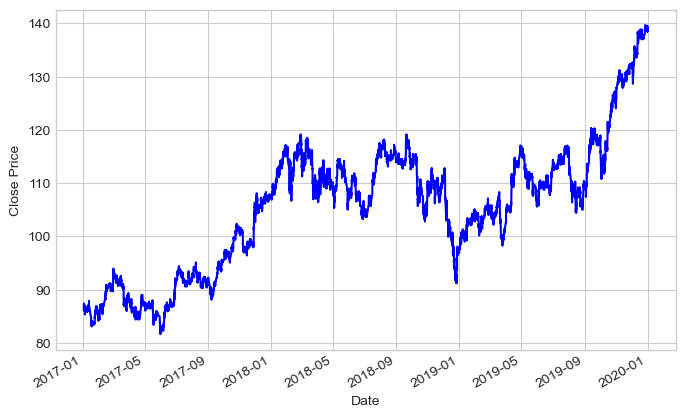

In [3]:

# Read the data
data = pd.read_csv('/Users/nacho/Documents/GitHub/python_course/books/Machine-Learning-Trading/assets/machine-learning-in-trading-main-main/data_modules/JPM_2017_2019.csv', index_col=0)
data.index = pd.to_datetime(data.index)

# Plot the data
data.close.plot(figsize=(8,5), color='b')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.show()

## Target Variable
Target variable is what the ML model tries to predict in order to solve the problem statement. Remember that we had denoted it with the letter `y`.

Given our problem statement: **Whether to buy $JPM stock or not?** We will create a column, `signal`. The `signal` column will have two labels, `1` and `0`.

Whenever the label es `1`, the model indicates a *buy* signal. And whenever the label is `0`, the model indicates a *do not buy* signal. We will assign `1` to the `signal` column whenever the future returns will be greater than `0`.


The `future_returns` can be calculated using the `pct_change` method of `pandas`. The `pct_change` method will calculate the percentage change for the current time period.

In the previous chapter we've looked the next day's returns to form the target variables, buy or sell. The concept is similar here. Since we want future returns, we will shift the percentage change for the current period to the previous time period. This can be donde using the `shift` method of `pandas`.

```python
DataFrame[column].pct_change().shift(period)
```

Where:

1. `column` The column for which the percentage change is to be calculated.
2. `period` The period to shift the series. To shift to the current value to the previous time period, the `period` will be `-1`.

In [4]:
# Create a column 'future_returns' with the calculation of % change
data['future_returns'] = data['close'].pct_change().shift(-1)

# Create the signal column
data['signal'] = np.where(data['future_returns'] > 0, 1, 0)

data[['close', 'signal']].head()

,close,signal
2017-01-03 09:45:00+00:00,87.39,0
2017-01-03 10:00:00+00:00,87.19,1
2017-01-03 10:15:00+00:00,87.30,1
2017-01-03 10:30:00+00:00,87.38,0
2017-01-03 10:45:00+00:00,87.13,0


As we can see in the above table, the close price from second row to third row is increased, and therefore the signal column in second row is marked as `1`. If you buy when the signal is `1`, it's going to result in positive returns for you.

Our aim is to develop a ML model which can accurately forecast when to buy.

### Features
In order to predict the `signal`, we will create the input variables for the ML model. These input variables are called `features`. The features are referred as `X`. You can create features in such a way that each feature in your dataset has some predictive power.

We will start by creating the 15-minute, 30-minute, and 75-minute prior percentage change columns.

In [5]:
# Create a column 'pct_change' with the 15-minute prior % change
data['pct_change'] = data['close'].pct_change()

# Create a column 'pct_change' with the 30-minute prior % change
data['pct_change2'] = data['close'].pct_change(2)

# Create a column 'pct_change' with the 75-minute prior % change
data['pct_change5'] = data['close'].pct_change(5)

Next, we will calculate the technical indicators, RSI and ADX. These can be done using the `RSI` and `ADX` method of the `talib` library.

Syntax:

```python
import talib as ta
ta.RSI(data, timeperiod)
ta.ADX(data_high, data_low, data_open, timeperiod)
```

Since there are 6.5 trading hours in a day, and ours is a 15-minute data, the time period will be $6.5 \times 4$

In [6]:
# Create a column by the name RSI
# Assign the RSI values to it
data['rsi'] = ta.RSI(data['close'].values, timeperiod=int(6.5*4))

# Create a column by the name ADX
# Assign the ADX values to it
data['adx'] = ta.ADX(data['high'].values,
                     data['low'].values,
                     data['open'].values,
                     timeperiod=int(6.5*4))

We will now create the Simple Moving Average and Rolling Correlation of the close price. This can be donde by using the `mean` and the `corr` method of the `pandas` library.

Syntax:

```python
DataFrame[column].rolling(window).mean()
DataFrame[column].rolling(window).corr()
```

Where:
1. `column` The column to perform the operation on.
2. `window` The span of the rolling window.

We will calculate the daily moving average and correlation

In [7]:
# Create a column by the name sma
# Asign SMA values to it
data['sma'] = data['close'].rolling(window=int(6.5*4)).mean()


# Create a column by the name corr
# Assign the correlation values to it
data['corr'] = data['close'].rolling(window=int(6.5*4)).corr(data['sma'])

Let us now calculate the volatility of the stock. This can be donde by calculating the rolling standard deviation of the `pct_change` column.

In [8]:
# 1-day and 2-day volatiliy
data['volatility'] = data.rolling(int(6.5*4),min_periods=int(6.5*4))['pct_change'].std()*100

data['volatility2'] = data.rolling(int(6.5*8),min_periods=int(6.5*8))['pct_change'].std()*100

### Create X and Y
Before creating the features (`X`) and target (`Y`), we will drop the rows with any missing values.

In [9]:
# Drop the missing values
data.dropna(inplace=True)

Store the `signal` column in `y` and features in `X`. The columns in the variable `X` will be the input for the ML model and the `signal` column in `y` will be the output that the ML model will predict.

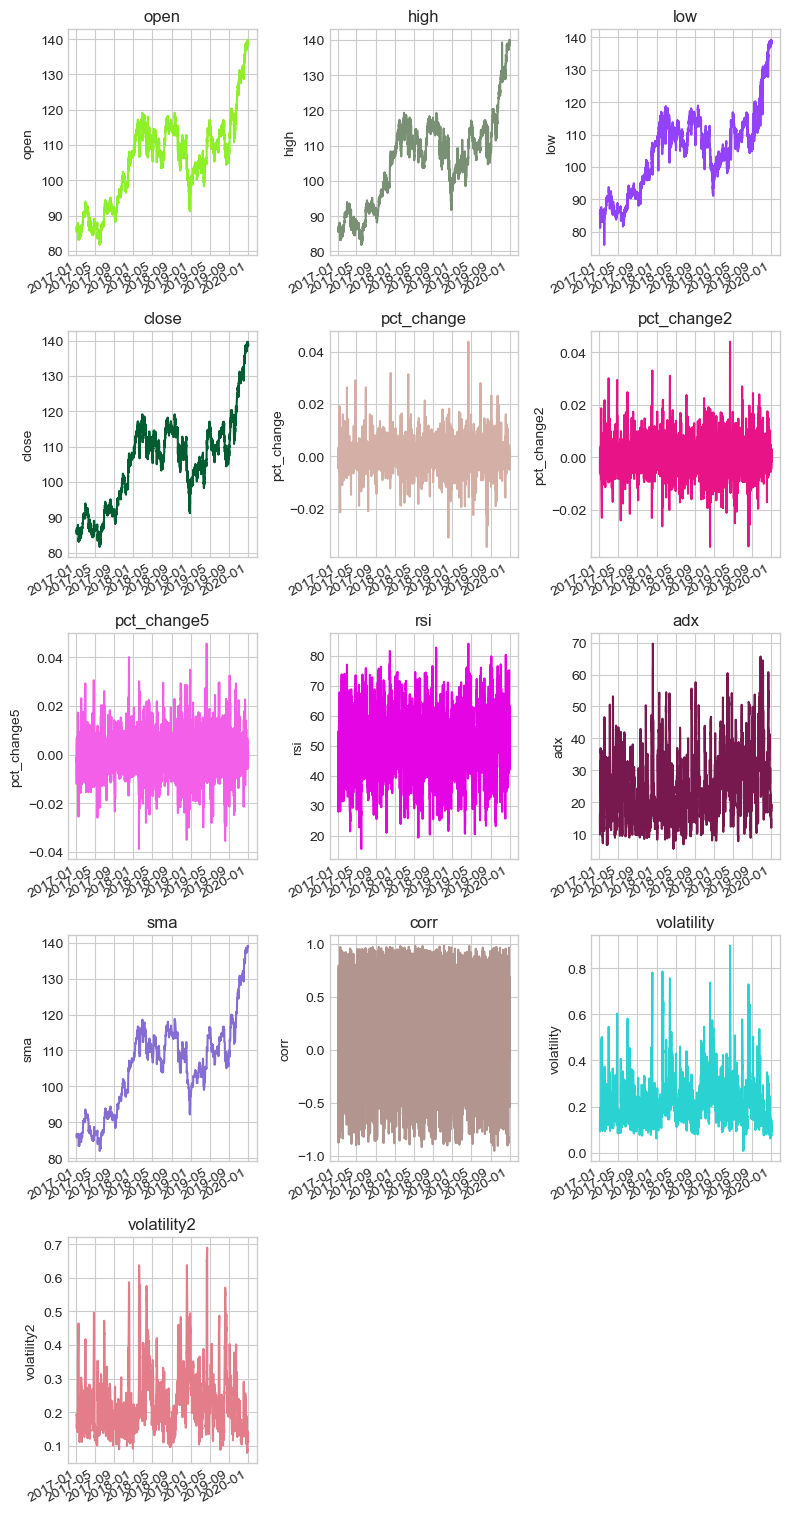

In [10]:
# Target
y = data[['signal']].copy()

# Features
X = data[['open', 'high', 'low', 'close', 'pct_change', 'pct_change2', 'pct_change5', 'rsi', 'adx', 'sma', 'corr', 'volatility', 'volatility2']].copy()

i = 1

# Set the number of rows in subplot
nrows = int(X.shape[1]+1/3)
for feature in X.columns:
    plt.subplot(nrows, 3, i)

    # Plot the feature
    X[feature].plot(figsize=(8,3*X.shape[1]),
                    color=np.random.rand(3,))
    plt.ylabel(feature)
    plt.title(feature)
    i += 1

plt.tight_layout()
plt.show()

### Stationary Check
We've seen that most ML algorithms require stationary features, we will drop the non-stationary features of `X`.

We can use the `adfuller` method from the `statsmodel` library to perform this test in Python and compra the $p$-value.
+ If the $p$-value is less than or equal to `0.05`, you reject `H0`
+ If the $p$-value is greater than `0.05`, you fail to reject `H0`

The `adfuller` method can be used as:

```python
from statsmodels.tsa.stattools import adfuller

result = adfuller(X)
```

The $p$-vale can be accessed as `result[1]`.

In [11]:
def stationary(series):
    """Function to check if the series is stationary or not."""

    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
    
# Check for stationarity
for col in X.columns:
    if stationary(data[col]) == 'not stationary':
        print('%s is not stationary. Dropping it. ' % col)
        X.drop(columns=[col], axis=1, inplace=True)

open is not stationary. Dropping it. 
high is not stationary. Dropping it. 
low is not stationary. Dropping it. 
close is not stationary. Dropping it. 
sma is not stationary. Dropping it. 


Thus, we can see that `open`, `high`, `low`, `close` and `sma` are not stationary so they are dropped from the dataset.

### Correlation 
You can check if two features have a high correlation, then essentially one of the features is redundant. We can remove that feature and improve learning of the model.

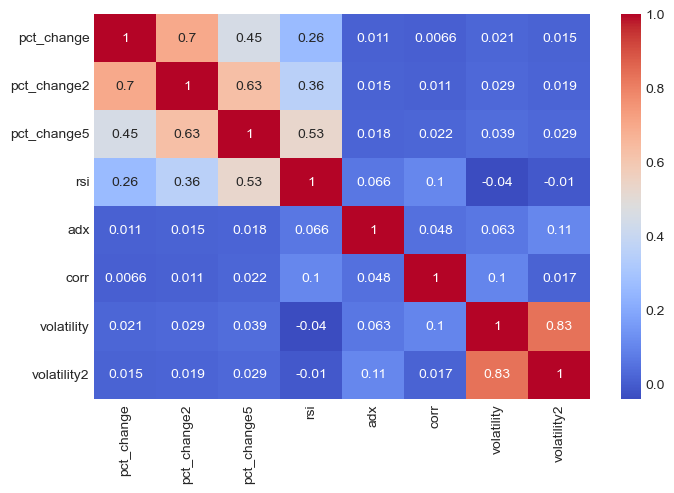

In [13]:
plt.figure(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()



We will define correlation to be high if it is greater than `0.7`. This choice is subjective but it shouldn't be very small, otherwise most of the features will look correlated. And at the same time not very high, otherwise none of the features will be correlated.

In the above output, we can see that the correlation between `volatility` and `volatiliy2` is above the threshold of `0.7`. Hence, we should drop any one of the above columens. We will drop the `volatility2` column.


An automated code to get the correlated pair is below:

In [14]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold"""
    # Claculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns

    for i in range(0, X.corr().shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring and redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index

print(get_pair_above_threshold(X, 0.7))

MultiIndex([('volatility', 'volatility2')],
           )


In [15]:
# Drop the highly correlated column
X = X.drop(columns=['volatility2'], axis=1)

Once we have removed the features which are not stationary and are correlated, we will display the features which we have selected.

### Display the Final Features

In [16]:
list(X.columns)

['pct_change',
 'pct_change2',
 'pct_change5',
 'rsi',
 'adx',
 'corr',
 'volatility']

Now we have the features and target variables.

What is next?

In the next chapter we will learn why is important to split the data into test and train data set.